# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession


from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, countDistinct,count, trim
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum
from pyspark.sql.types import IntegerType, FloatType,StringType

import pyspark.sql.functions as f

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler,Normalizer, MinMaxScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Customer Churn Project") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()

spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "/home/workspace/mini_sparkify_event_data.json"
sparkify_data = spark.read.json(path)

In [4]:
sparkify_data.show(n=3,truncate=False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song             |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logged In|Colin    |M     |50           

In [5]:
sparkify_data_count=sparkify_data.count()

print("The total number of recs in original dataset is {}".format(sparkify_data_count))

The total number of recs in original dataset is 286500


In [6]:
sparkify_data_nonmiss=sparkify_data.dropna(how='any',subset=['sessionId','userId'])

print("The total number of recs in dataset after removing duplicates based on user and session id is {}".format(sparkify_data_count))
sparkify_data_nonmiss.count()

The total number of recs in dataset after removing duplicates based on user and session id is 286500


286500

In [7]:
sparkify_data_valid=sparkify_data_nonmiss.filter(sparkify_data_nonmiss['userId']!="")
sparkify_data_valid_count=sparkify_data_valid.count()

print("The total number of recs in dataset after removing blank on userid is {}".format(sparkify_data_valid_count))


The total number of recs in dataset after removing blank on userid is 278154


In [8]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
sparkify_data_valid = sparkify_data_valid.withColumn("time", get_time(sparkify_data_valid.ts))


In [9]:
user_ids=sparkify_data_valid.select('userId').dropDuplicates().count()

print("The total number of Unique Users in dataset is {}".format(user_ids))


session_ids=sparkify_data_valid.select('sessionId').dropDuplicates().count()

print("The total number of Unique SessionIds in dataset is {}".format(session_ids))

pages=sparkify_data_valid.select('page').dropDuplicates().count()

print("The total number of Unique Pages in dataset is {}".format(pages))

The total number of Unique Users in dataset is 225
The total number of Unique SessionIds in dataset is 2312
The total number of Unique Pages in dataset is 19


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
#Churn Definition
churn_def=udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
df = sparkify_data_valid.withColumn("churn", churn_def("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("churn", fsum("churn").over(windowval))

In [11]:
df_pandas=df.toPandas()

In [12]:
df_pandas.head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 12:58:54,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:02:16,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:05:32,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:05:33,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:09:55,0


In [13]:
def barplot_visualize(x_label,y_label,df,title):
    '''
        Plots a seaborn barchart based on the inputs provided
        input: 
            x_lable - Values to be displayed on x-axis
            y_label - Values to be displayed on y-axis
            df - Data to be plotted
        outut: None
    '''
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.title(title,fontsize= 16)
    ax = sns.barplot(y=y_label, x=x_label, data=df.toPandas())

+-----+-----+
|Churn|Users|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



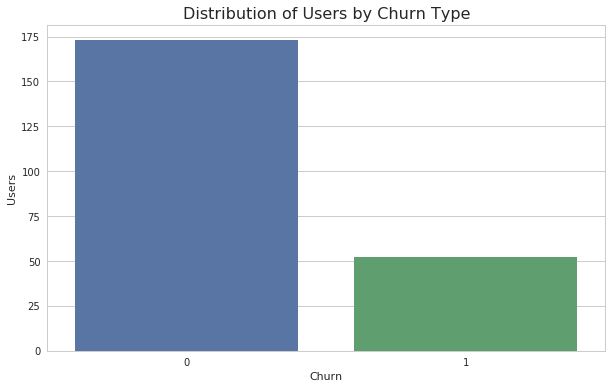

In [14]:
#Distribution of users by Churn Type
churn_counts = df.groupBy("Churn").agg(countDistinct("userId").alias("Users"))
churn_counts.show()
barplot_visualize(x_label="Churn",y_label="Users",df=churn_counts,title='Distribution of Users by Churn Type')

Out of 225, 52 users were identified to be churned; this is about 24% of the universe.

+------+-----+
|Gender|Users|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



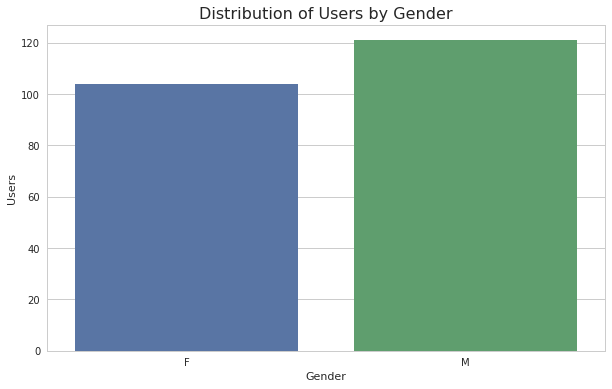

In [15]:
#Distribution of users by Gender Type
gender_counts = df.groupBy("Gender").agg(countDistinct("userId").alias("Users"))
gender_counts.show()
barplot_visualize(x_label="Gender",y_label="Users",df=gender_counts,title='Distribution of Users by Gender')

Out of 225, 121 users were identified to be male; this is about 54% of the universe.

+-----+-----+
|Level|Users|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



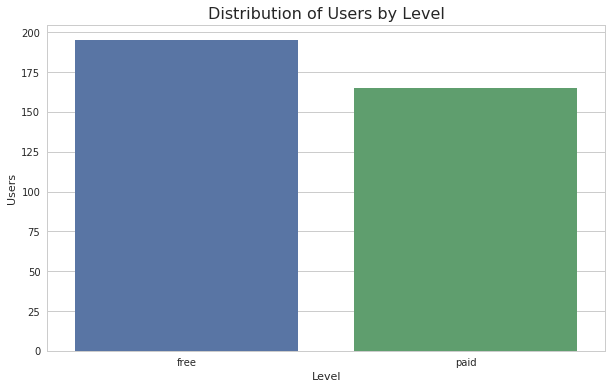

In [16]:
level_counts = df.groupBy("Level").agg(countDistinct("userId").alias("Users"))
level_counts.show()
barplot_visualize(x_label="Level",y_label="Users",df=level_counts,title='Distribution of Users by Level')

Based on results seen above, a user may have the opportunity to first be a 'free' user and then a 'paid' user
and vice-versa. It would make more sense to take a look at recent level.

Text(0,0.5,'Users')

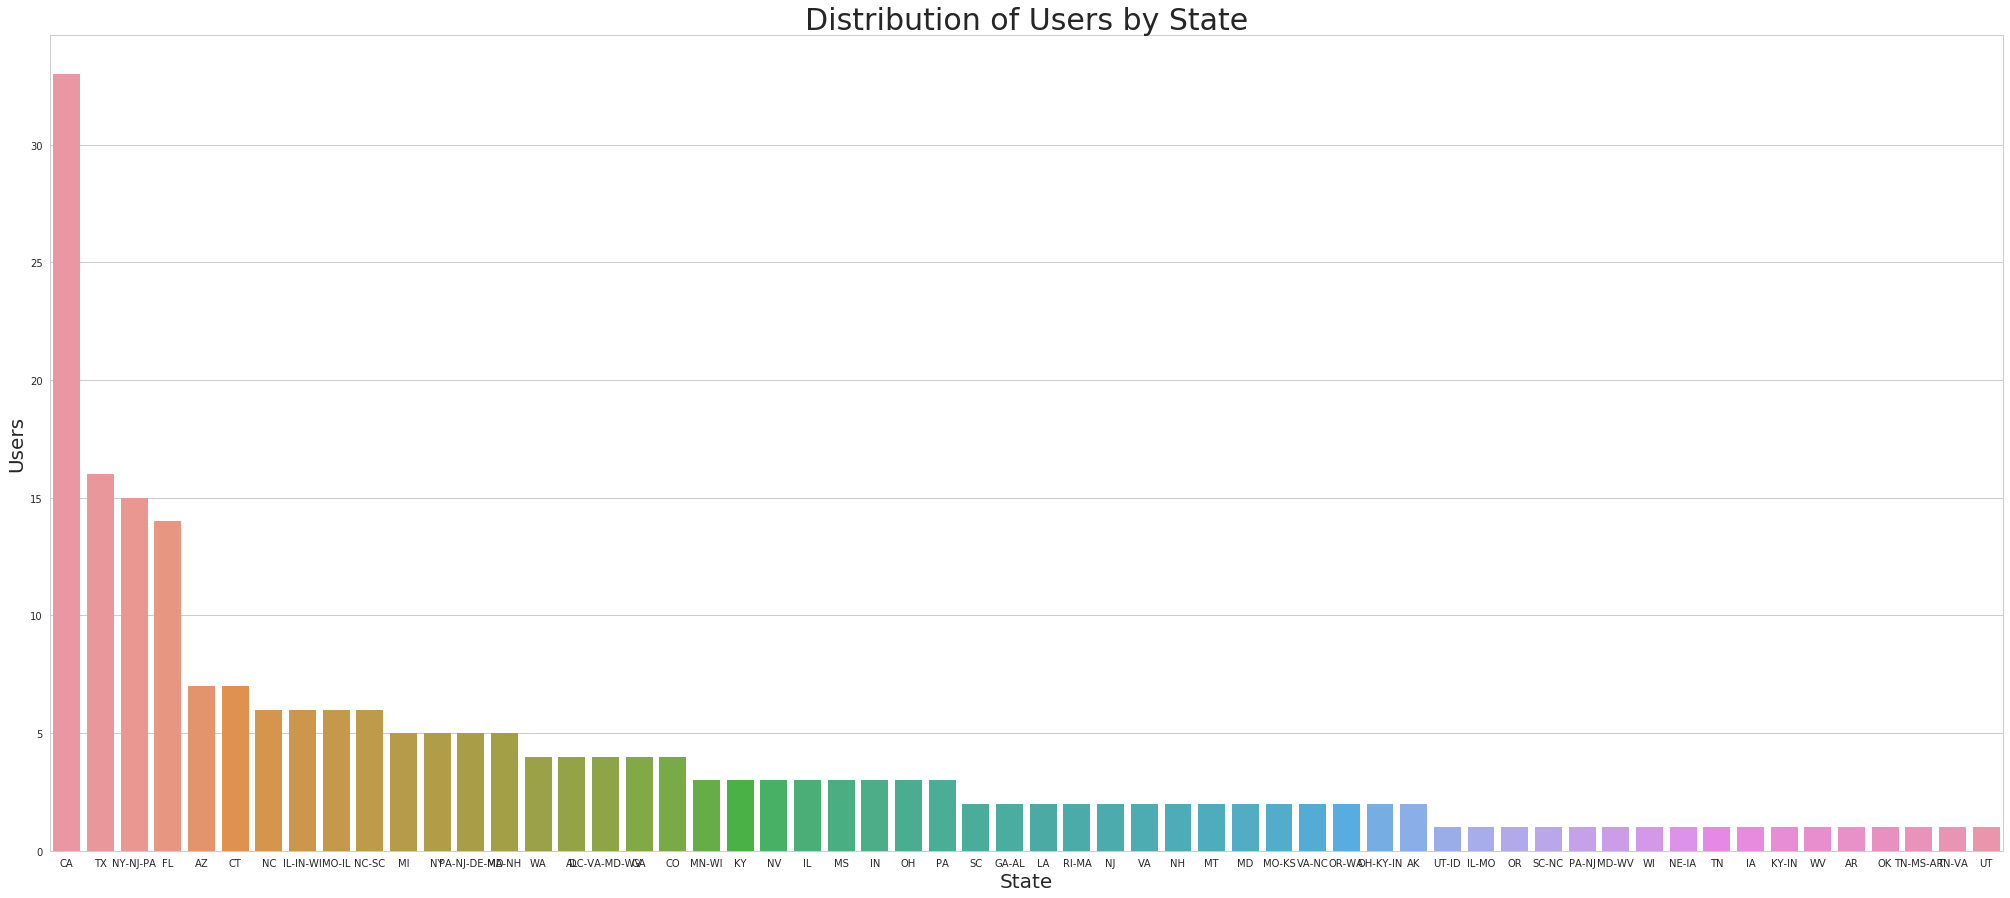

In [17]:
#Distribution of users by State
split_col = f.split(df['location'], ',')
df = df.withColumn('City', trim(split_col.getItem(0)))\
        .withColumn('State', trim(split_col.getItem(1)))

state_count = df.groupBy("State").agg(countDistinct("userId").alias("Users"))\
                .sort(col("Users").desc())

title = "Distribution of Users by State"

sns.set(style="whitegrid")

plt.figure(figsize=(35, 15))
plt.title(title,fontsize= 30)
ax = sns.barplot(x="State",y="Users", data=state_count.toPandas())

ax.set_xlabel("State",fontsize=20)
ax.set_ylabel("Users",fontsize=20)

The top 5 states that users of this service belong to are : California, Texas, New York, Florida and Arizona.

In [18]:
#Distribution of users by userAgent
pd.set_option('max_colwidth', 800)
userAgent_counts = df.groupBy("userAgent").agg(countDistinct("userId").alias("Users"))\
                    .sort(col("Users").desc()).toPandas()
userAgent_counts

,userAgent,Users
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",24
1,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,18
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",16
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",12
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4""",12
5,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",10
6,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2""",10
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:31.0) Gecko/20100101 Firefox/31.0,9
8,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53""",8
9,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",7


The userAgent column has set of interesting features that we can be extracted such as - Platform and Browser Type.

In [19]:
#Extract Browser Type
def get_browser(x):
    if 'Firefox' in x:
        return 'firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'chrome'
        else:
            return 'safari'
    elif 'Trident' in x:
        return 'ie'
    else:
        return np.NaN
userAgent_counts['browser'] = userAgent_counts['userAgent'].apply(get_browser)

In [20]:
#Extract Platform Type
def get_os(x):
    if 'Windows' in x:
        return 'windows'
    elif 'Macintosh' in x:
        return 'mac'
    elif 'Linux' in x:
        return 'linux'
    elif 'iPhone' in x:
        return 'iphone'
    elif 'iPad' in x:
        return 'ipad'
    else:
        return np.NaN
userAgent_counts['os'] = userAgent_counts['userAgent'].apply(get_os)

Distribution of Users by Type of Browser

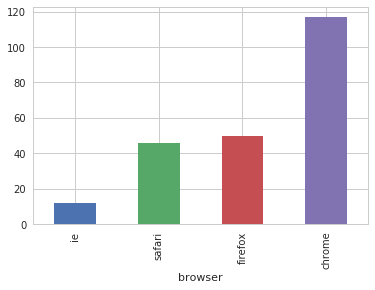

In [21]:
userAgent_counts.groupby('browser')['Users'].sum().sort_values().plot(kind='bar')

About 54% of users leveraged Chrome as a browser.

Distribution of Users by Type of OS

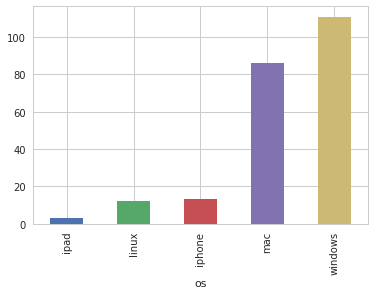

In [22]:
userAgent_counts.groupby('os')['Users'].sum().sort_values().plot(kind='bar')

About 48% of users leveraged Windows as OS.

+-----+------+-----+-----+------------------+
|Churn|Gender|Users|total|           Percent|
+-----+------+-----+-----+------------------+
|    0|     F|   84|  104| 80.76923076923077|
|    1|     F|   20|  104| 19.23076923076923|
|    1|     M|   32|  121|26.446280991735538|
|    0|     M|   89|  121| 73.55371900826447|
+-----+------+-----+-----+------------------+



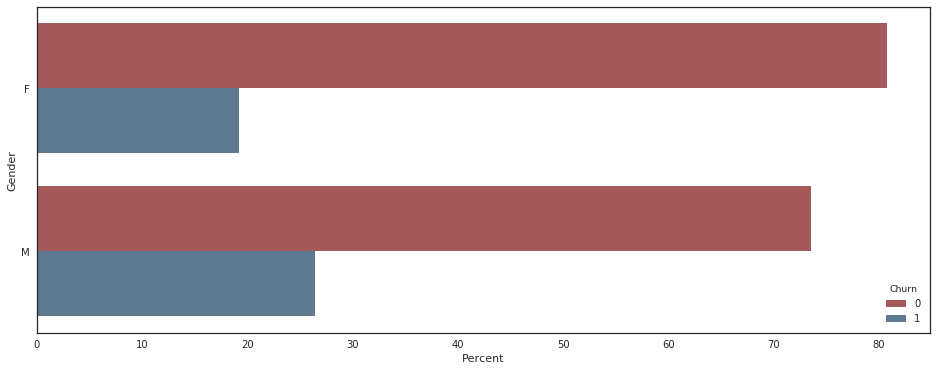

In [23]:
# Distribution of Users by Churn and Gender
churn_gender_counts = df.groupBy(["Churn","Gender"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', f.sum('Users').over(Window.partitionBy('Gender')))\
                      .withColumn('Percent', f.col('Users')*100/f.col('total'))

churn_gender_counts.show()

sns.set_style("white")
plt.figure(figsize=(16, 6))
sns.set_palette("Set1",n_colors=8, desat=.5)
ax = sns.barplot(x="Percent", y="Gender", hue="Churn", data=churn_gender_counts.toPandas(),capsize=.2)


Based on results above, the churn rate for males is higher than females (26% vs 19%).

In [24]:
# Obtain whether a user is paid or free
#level Definition
level_def=udf(lambda x: 1 if x == "free" else 0, IntegerType())
# apply to the dataframe
df = df.withColumn("level_free", level_def("level"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
df = df.withColumn("level_free", fmax("level_free").over(windowval))

+-----+----------+-----+-----+-----------------+
|Churn|level_free|Users|total|          Percent|
+-----+----------+-----+-----+-----------------+
|    1|         1|   46|  195|23.58974358974359|
|    0|         1|  149|  195|76.41025641025641|
|    0|         0|   24|   30|             80.0|
|    1|         0|    6|   30|             20.0|
+-----+----------+-----+-----+-----------------+



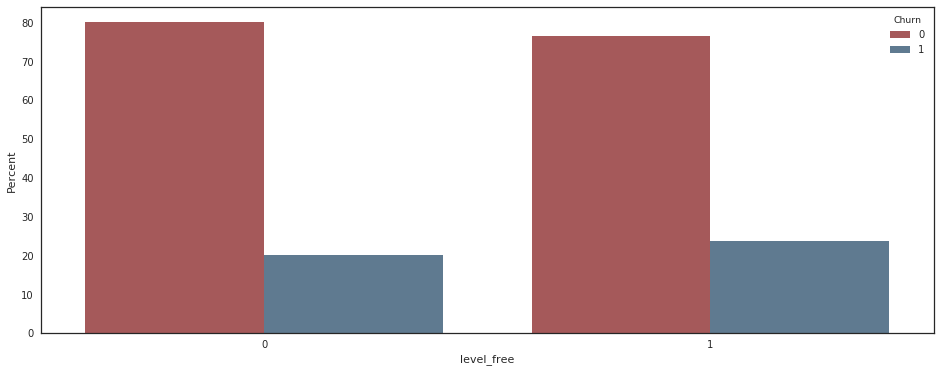

In [25]:
# Distribution of Users by Churn and Level
churn_level_counts = df.groupBy(["Churn","level_free"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', f.sum('Users').over(Window.partitionBy('level_free')))\
                      .withColumn('Percent', f.col('Users')*100/f.col('total'))

churn_level_counts.show()


sns.set_style("white")
plt.figure(figsize=(16, 6))
sns.set_palette("Set1",n_colors=8, desat=.5)
ax = sns.barplot(x="level_free", y="Percent", hue="Churn", data=churn_level_counts.toPandas(),capsize=.2)


Based on results above, the churn rate for 'free' user is higher than 'paid' user (24% vs 20%).

In [26]:
browser = udf(lambda x : get_browser(x))
df = df.withColumn('browser',browser(df.userAgent))

os = udf(lambda x : get_os(x))
df = df.withColumn('os',os(df.userAgent))

+-----+-------+-----+-----+------------------+
|Churn|Browser|Users|total|           Percent|
+-----+-------+-----+-----+------------------+
|    1|firefox|   16|   50|              32.0|
|    0|firefox|   34|   50|              68.0|
|    0| chrome|   92|  117| 78.63247863247864|
|    1| chrome|   25|  117|21.367521367521366|
|    1|     ie|    1|   12| 8.333333333333334|
|    0|     ie|   11|   12| 91.66666666666667|
|    0| safari|   36|   46| 78.26086956521739|
|    1| safari|   10|   46| 21.73913043478261|
+-----+-------+-----+-----+------------------+



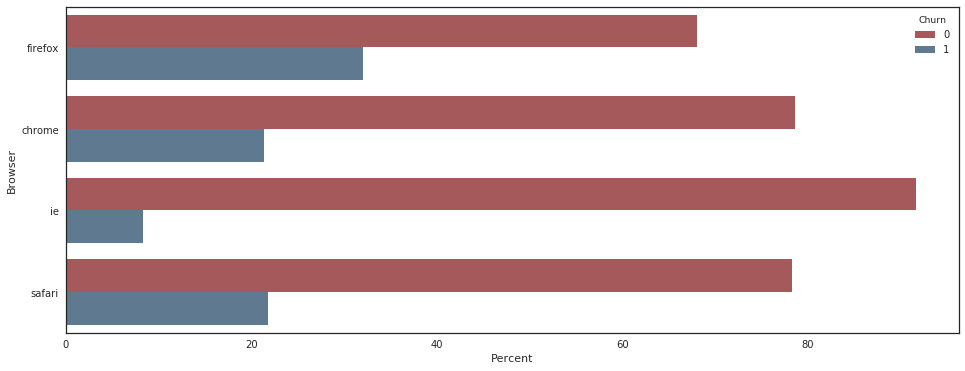

In [27]:
# Distribution of Users by Churn and Browser Type
churn_browser_counts = df.groupBy(["Churn","Browser"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', f.sum('Users').over(Window.partitionBy('Browser')))\
                      .withColumn('Percent', f.col('Users')*100/f.col('total'))

churn_browser_counts.show()


sns.set_style("white")
plt.figure(figsize=(16, 6))
sns.set_palette("Set1",n_colors=8, desat=.5)
ax = sns.barplot(x="Percent", y="Browser", hue="Churn", data=churn_browser_counts.toPandas(),capsize=.2)

Based on results above, the churn rate for 'Firefox' browser is significantly higher than other types of browser.

+-----+-------+-----+-----+------------------+
|Churn|     OS|Users|total|           Percent|
+-----+-------+-----+-----+------------------+
|    0| iphone|    9|   13| 69.23076923076923|
|    1| iphone|    4|   13| 30.76923076923077|
|    1|  linux|    5|   12|41.666666666666664|
|    0|  linux|    7|   12|58.333333333333336|
|    1|    mac|   19|   86|22.093023255813954|
|    0|    mac|   67|   86| 77.90697674418605|
|    0|   ipad|    3|    3|             100.0|
|    0|windows|   87|  111| 78.37837837837837|
|    1|windows|   24|  111| 21.62162162162162|
+-----+-------+-----+-----+------------------+



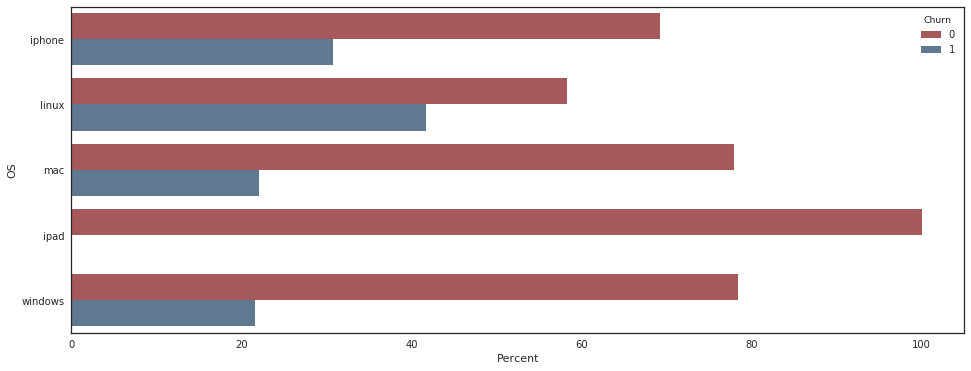

In [28]:
# Distribution of Users by Churn and OS Type
churn_os_counts = df.groupBy(["Churn","OS"]).agg(countDistinct("userId").alias("Users"))\
                      .withColumn('total', f.sum('Users').over(Window.partitionBy('os')))\
                      .withColumn('Percent', f.col('Users')*100/f.col('total'))

churn_os_counts.show()


sns.set_style("white")
plt.figure(figsize=(16, 6))
sns.set_palette("Set1",n_colors=8, desat=.5)
ax = sns.barplot(x="Percent", y="OS", hue="Churn", data=churn_os_counts.toPandas(),capsize=.2)

Based on results above, the churn rate for 'Linux' OS user is higher than other  .

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The following features were incorporated to predict churn at the user level 

# Numerical Features:
1. Total number of songs 
2. Average length of session
3. Number of songs that received a thumb up
4. Number of songs that received a thumb down
5. Number of friend additions
6. Number of advertisements seen
7. Number of playlist additions
8. Number of unique artists and songs listened to
9. Number of sessions

# Categorial Features:
1. Gender type
2. Browser type
3. OS type
4. Level of the user
5. State a user lives in

In [29]:
def dummy_feature(feat_name):
    '''
    Create Dummy Variables for Categorical Features
    '''
    feat=df.groupBy("userID").pivot(feat_name).agg(f.lit(1)).na.fill(0)
    feat= feat.select([f.col(c).alias(feat_name+"_"+c+"") if c not in 'userID' else c for c in feat.columns])
    return feat

In [30]:
def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = dummy_feature('gender')
    feature_browser = dummy_feature('browser')
    feature_os = dummy_feature('os')
    feature_state = dummy_feature('State')
    
    result = feature_gender.join(feature_browser,on='userId',how='inner').\
                            join(feature_os,on='userId',how='inner').\
                            join(feature_state,on='userId',how='inner')
    return result

categorical_features = get_categorical_features()

In [31]:
def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    #length
    feature_length = df.select(["userId", "length"])\
                    .groupby(["userId"]).agg(avg('length').alias('mean_length'),\
                     fmax('length').alias('max_length'),\
                     fmin('length').alias('min_length'),\
                     fsum('length').alias('tot_length'))
    

    page_count = df.select(["userId","page"]).groupby(["userId","page"]).count()

    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)

    temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
   
    cols = temp1.columns[1:]

    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    #churn - Target Variabe
    
    feature_churn = df.groupBy("userID").agg(fmax("churn").alias("label"))
    
    
    feature_level= df.groupBy("userID").agg(fmax("level_free").alias("level_free"))
    
    #Total songs number
    feature_songs_count=df.filter(df.page=='NextSong')\
                           .select(['userID','song'])\
                           .groupBy(["userID"])\
                           .agg(count("song").alias("songs_count")) 
    
    
    #unique songs number
    feature_unique_songs_count=df.filter(df.page=='NextSong')\
                           .select(['userID','song'])\
                           .groupBy(["userID"])\
                           .agg(countDistinct("song").alias("songs_unique_count")) 
    
    #unique artists artist
    feature_unique_artist_count=df.filter(df.page=='NextSong')\
                           .select(['userID','artist'])\
                           .groupBy(["userID"])\
                           .agg(countDistinct("artist").alias("artist_unique_count"))
   
    #unique session count
    feature_session_count=df.select(['userID','sessionID'])\
                            .groupBy(["userID"])\
                            .agg(countDistinct("sessionID").alias("session_count"))
    
    result=feature_churn.join(feature_length,on='userId',how='inner').\
                            join(feature_songs_count,on='userId',how='inner').\
                            join(feature_unique_songs_count,on='userId',how='inner').\
                            join(feature_unique_artist_count,on='userId',how='inner').\
                            join(feature_session_count,on='userId',how='inner').\
                            join(feature_page,on='userId',how='inner').\
                            join(feature_level,on='userId',how='inner')
    return result

numerical_features = get_numerical_features()

In [32]:
def combine_features():
    '''
    joins both categorical and numerical features together
    '''
    
    overall=numerical_features.join(categorical_features,on='userID',how='inner')
    overall = overall.fillna(0)
    return overall

combine_features=combine_features()

In [33]:
print((combine_features.count(), len(combine_features.columns)))

(225, 87)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Below are some classification models which I'd like to attempt :
1. Logistic Regression
2. Gradient Boosted Trees Classification
3. Support Vector Machines Classification
4. Random Forest Classification

In [34]:
#Identify the columns for vectorize
input_cols = combine_features.columns[2:]

# Split the data set into train and test
train, test = combine_features.randomSplit([0.80, 0.20], seed=45)

#Vectorize and Scale
assembler = VectorAssembler(inputCols=input_cols, outputCol="NumFeatures")
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="features")

In [35]:
#Empty Dataframe for saving results of model evaluation
pd_ml_results = []
pd_ml_results = pd.DataFrame(pd_ml_results)
pd_ml_results['Evaluations'] = ['Accuracy','F1_Score']

In [36]:
#Define Machine learning classifiers
lr_classifier = LogisticRegression(maxIter=10,regParam=0.0,elasticNetParam=0)
gbt_classifier = GBTClassifier(maxIter=10,seed=42)
svm_classifier = LinearSVC(maxIter=10)
rf_classifier = RandomForestClassifier()

In [37]:
#Define pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, lr_classifier]);
gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt_classifier]);
svm_pipeline = Pipeline(stages=[assembler, scaler, svm_classifier]);
rf_pipeline = Pipeline(stages=[assembler, scaler, rf_classifier]);

In [38]:
#Define param grids
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr_classifier.maxIter, [1,5]) \
    .addGrid(lr_classifier.regParam, [0.1, 0.01]) \
    .build()

gbt_paramGrid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxIter, [1,5]) \
    .addGrid(gbt_classifier.maxDepth, [2, 4]) \
    .build()

svm_paramGrid = ParamGridBuilder() \
    .addGrid(svm_classifier.maxIter, [1, 5]) \
    .build()

rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.impurity,['entropy', 'gini']) \
    .addGrid(rf_classifier.maxDepth,[2, 4]) \
    .addGrid(rf_classifier.numTrees,[5, 10]) \
    .build()

In [39]:
#Define Cross Validators
lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

gbt_crossval = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

svm_crossval = CrossValidator(estimator=svm_pipeline,
                          estimatorParamMaps=svm_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2) 

rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=2)

# Logistic Regression

In [40]:
lr_model = lr_crossval.fit(train)
lr_predict = lr_model.transform(test)


lr_evaluator = MulticlassClassificationEvaluator(labelCol ="label",predictionCol="prediction")

lr_accuracy = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "accuracy"})
lr_f1score = lr_evaluator.evaluate(lr_predict, {lr_evaluator.metricName: "f1"})


print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(lr_accuracy))
print('F-1 Score:{}'.format(lr_f1score))

pd_ml_results['LogisticRegression'] = [lr_accuracy,lr_f1score]

Logistic Regression Metrics:
Accuracy: 0.75
F-1 Score:0.7071428571428571


# Gradient Boosting Trees Classification

In [41]:
gbt_model = gbt_crossval.fit(train)
gbt_predict = gbt_model.transform(test)


gbt_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

gbt_accuracy = gbt_evaluator.evaluate(gbt_predict, {gbt_evaluator.metricName: "accuracy"})
gbt_f1score = gbt_evaluator.evaluate(gbt_predict, {gbt_evaluator.metricName: "f1"})
    

print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(gbt_accuracy))
print('F-1 Score:{}'.format(gbt_f1score))

pd_ml_results['GradientBoostedTrees'] = [gbt_accuracy,gbt_f1score]

Gradient Boosted Trees Metrics:
Accuracy: 0.775
F-1 Score:0.7680252583237658


# Support Vector Machines Classification

In [42]:
svm_model = svm_crossval.fit(train)
svm_predict = svm_model.transform(test)


svm_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

svm_accuracy = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "accuracy"})
svm_f1score = svm_evaluator.evaluate(svm_predict, {svm_evaluator.metricName: "f1"})


print('SupportVectorMachine Metrics:')
print('Accuracy: {}'.format(svm_accuracy))
print('F-1 Score:{}'.format(svm_f1score))

pd_ml_results['SupportVectorMachine(SVM)'] = [svm_accuracy,svm_f1score]

SupportVectorMachine Metrics:
Accuracy: 0.825
F-1 Score:0.7458904109589041


# Random Forest Classification

In [43]:
rf_model = rf_crossval.fit(train)
rf_predict = rf_model.transform(test)


rf_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

rf_accuracy = rf_evaluator.evaluate(rf_predict, {rf_evaluator.metricName: "accuracy"})
rf_f1score = rf_evaluator.evaluate(rf_predict, {rf_evaluator.metricName: "f1"})


print('Random Forest Metrics:')
print('Accuracy: {}'.format(rf_accuracy))
print('F-1 Score:{}'.format(rf_f1score))

pd_ml_results['RandomForest'] = [rf_accuracy,rf_f1score]

Random Forest Metrics:
Accuracy: 0.775
F-1 Score:0.7204225352112676


# Final Results - Evaluation Metrics 

In [44]:
pd_ml_results

,Evaluations,LogisticRegression,GradientBoostedTrees,SupportVectorMachine(SVM),RandomForest
0,Accuracy,0.750000,0.775000,0.82500,0.775000
1,F1_Score,0.707143,0.768025,0.74589,0.720423


Based on results above, the Gradient Boosted Trees Classification model is the best model which has the highest F1 Score of 0.77.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [2]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Sparkify.ipynb to html',
 '[NbConvertApp] Writing 571899 bytes to Sparkify.html',
 '[NbConvertApp] Converting notebook Sparkify-zh.ipynb to html',
 '[NbConvertApp] Writing 279513 bytes to Sparkify-zh.html']